#1.Read file


In [186]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
#đọc dữ liệu file train và test
#train
path = "/content/drive/MyDrive/Project/intruction_detection_project/kdd_train.csv"
train_df = pd.read_csv(path)

#test
path = "/content/drive/MyDrive/Project/intruction_detection_project/kdd_test.csv"
test_df = pd.read_csv(path)

In [189]:
#Phân loại những data có kiểu category
#change Dtype
features = ["protocol_type","service","flag","land","wrong_fragment","is_host_login","urgent","logged_in","root_shell","su_attempted","is_guest_login","labels"]
def convert_cat(df,features) :
  for feature in features :
    df[feature] = df[feature].astype("category")
convert_cat(train_df, features)
convert_cat(test_df, features)

In [190]:
#xóa những cột không quá ảnh hưởng đến bài trên train_df
train_df = train_df.drop(labels ='num_outbound_cmds',axis = 1)
train_df = train_df.drop(labels ='is_host_login',axis = 1)

In [191]:
#những thuộc tính số lượng dưới 1 gộp thành vào other
label_better_1 = ["normal","neptune","satan","ipsweep","portsweep","smurf","nmap"]
train_df_labels_1 = list(train_df['labels'].unique())
train_df_labels_1 = set(train_df_labels_1) - set(label_better_1)
train_df_labels_1

test_df_labels_1 = list(test_df['labels'].unique())
test_df_labels_1 = set(test_df_labels_1) - set(label_better_1)
test_df_labels_1

#train_df.loc[label_under_1, ['labels']] ='other'
train_df['labels'] = train_df['labels'].replace(train_df_labels_1, 'other')
#train_df
test_df['labels'] = test_df['labels'].replace(test_df_labels_1, 'other')

In [192]:
#xóa vì num_root tương quan numcompromised đến 1
train_df = train_df.drop(labels ='num_root',axis = 1)
test_df = test_df.drop(labels ='num_root',axis = 1)

In [201]:
feature_cols = [i for i in train_df if i != 'labels']
x = cut_train_df[feature_cols]
y = cut_train_df['labels']
X_test =cut_test_df[feature_cols]
y_test = cut_test_df['labels']


In [202]:
#preprocess pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [203]:
num_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


In [204]:
num_features = [i for i in train_df if i != 'labels' and train_df[i].dtype != 'category']
cat_features = [i for i in train_df if i != 'labels' and train_df[i].dtype == 'category']

In [205]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [206]:
preprocessor.fit(x)
preprocessor.fit(X_test)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['duration', 'src_bytes', 'dst_bytes', 'hot',
                                  'num_failed_logins', 'num_compromised',
                                  'num_file_creations', 'num_shells',
                                  'num_access_files', 'count', 'srv_count',
                                  'serror_rate', 'srv_serror_rate',
                                  'rerror_rate', 'srv_rerror_rate',
                                  'sa...
                                  'dst_host_serror_rate',
                                  'dst_host_srv_serror_rate',
                                  'dst_host_rerror_rate',
                                  'dst_host_srv_rerror_rate']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['protocol_type', 'service', 'flag', 'land',
                                  'wrong_fragment', 'urgent', 'logged_in',
                                  'root_shell', 'su_attempted',
                                  'is_guest_login'])])

In [207]:
X = preprocessor.transform(x)#X -> X_train, X_val
X_test =preprocessor.transform(X_test)

In [209]:
from sklearn.model_selection import train_test_split

In [210]:
X_train, X_val, y_train,y_val = train_test_split(X,y, test_size = 0.2)

In [211]:

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
#binary classification
from sklearn.preprocessing import PolynomialFeatures
#sklearn model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score,classification_report, confusion_matrix

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer

# Showing Confusion Matrix

def plot_cm(y_true, y_pred, title):
    figsize=(14,14)
    #y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

neuron


In [212]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers

import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [213]:
X_train_reshaped = X_train.reshape(-1, 125)
X_train_reshaped.shape

(21932, 125)

In [214]:
X_test_reshaped = X_test.reshape(-1, 125)
X_test_reshaped.shape

(22544, 125)

In [215]:
X_val_reshaped = X_val.reshape(-1, 125)
X_val_reshaped.shape


(5484, 125)

In [216]:
y_train.unique()

['other', 'ipsweep', 'portsweep', 'neptune', 'smurf', 'satan', 'normal', 'nmap']
Categories (8, object): ['ipsweep', 'other', 'neptune', 'nmap', 'normal', 'portsweep', 'satan',
                         'smurf']

In [217]:
lable_map = {'normal':0, 'neptune':1, 'satan':2, 'smurf':3, 'ipsweep':4, 'other':5, 'nmap':6, 'portsweep':7}
y_train = y_train.map(lable_map)
y_test = y_test.map(lable_map)

In [218]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=8)

In [219]:
y_val = y_val.map(lable_map)
y_val = to_categorical(y_val, num_classes=8)

In [220]:
y_val

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [242]:
#chuỗi cái layer
from keras.models import Sequential
model = Sequential()


In [222]:
X_train.shape

(21932, 125)

In [280]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=125, activation='relu', input_shape=(125, ),
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=250, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),


    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=64, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),


    tf.keras.layers.Dense(units=32, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=16, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=8, activation='sigmoid'),
])

In [281]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [282]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 125)               15750     
                                                                 
 dropout_56 (Dropout)        (None, 125)               0         
                                                                 
 dense_70 (Dense)            (None, 250)               31500     
                                                                 
 dropout_57 (Dropout)        (None, 250)               0         
                                                                 
 dense_71 (Dense)            (None, 128)               32128     
                                                                 
 dropout_58 (Dropout)        (None, 128)               0         
                                                                 
 dense_72 (Dense)            (None, 64)              

In [284]:
history = model.fit(X_train_reshaped, y_train,validation_data=(X_val, y_val) ,epochs=300, verbose=30000)

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

In [285]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [286]:
y_pred = model.predict(X_test)

705/705 [==============================] - 1s 1ms/step


In [287]:
y_pred = np.argmax(y_pred, axis=-1)

In [288]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

0.8712188865628698

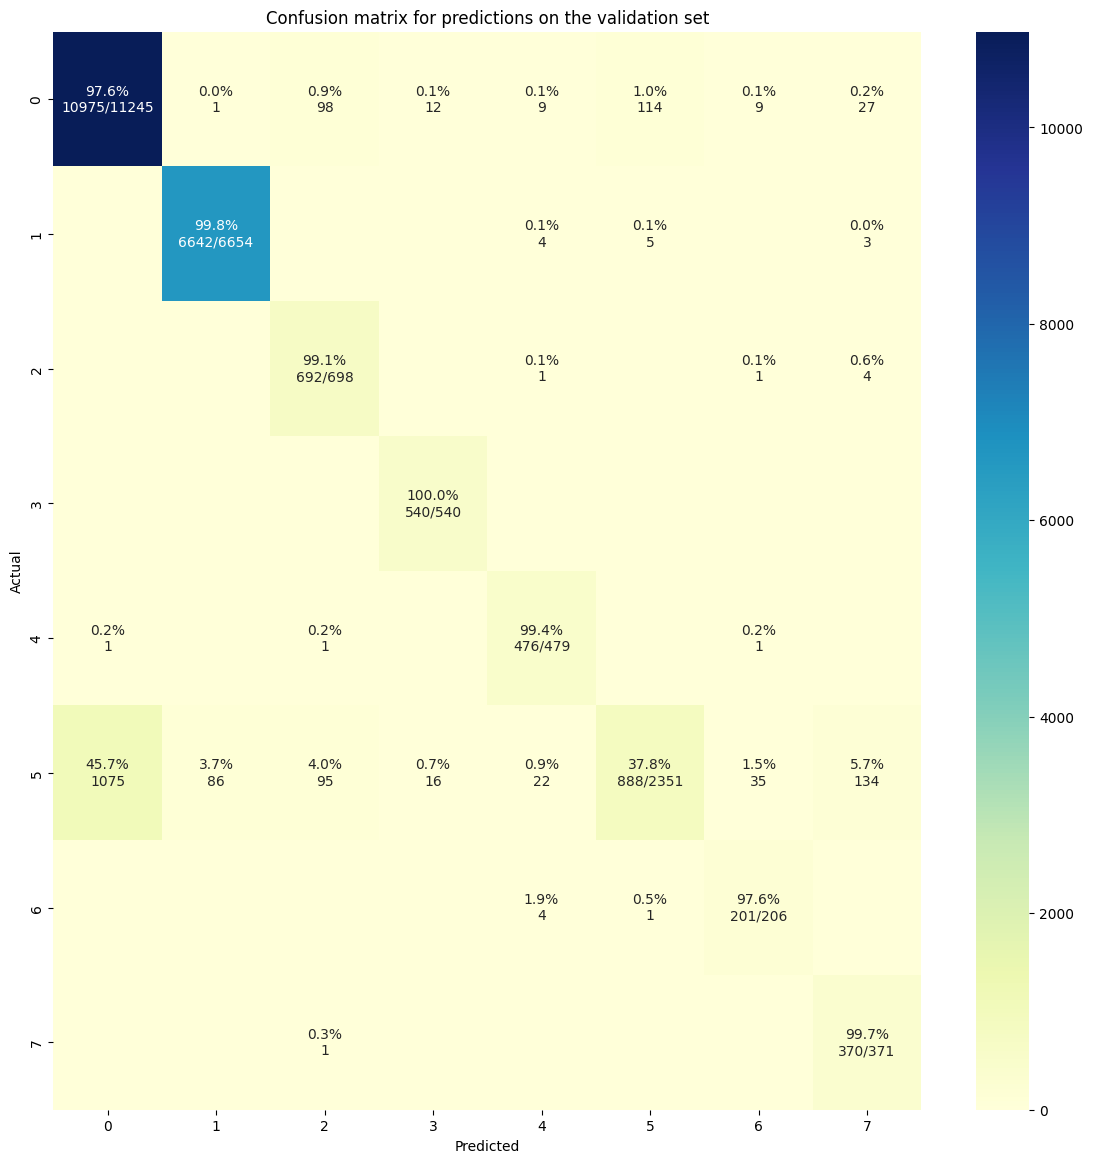

In [289]:
plot_cm(y_test,y_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred, average = 'macro')

In [251]:
y_pred

array([0, 0, 0, ..., 1, 7, 0])

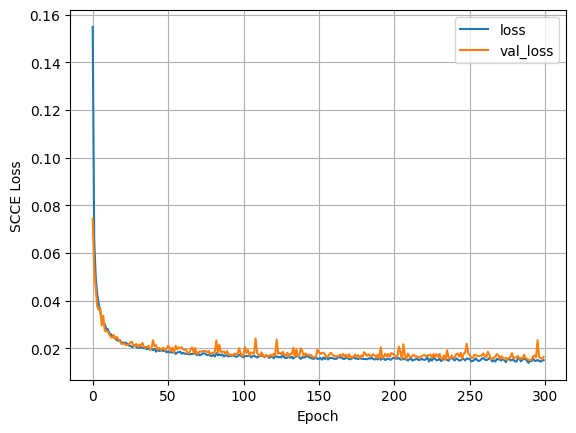

In [290]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

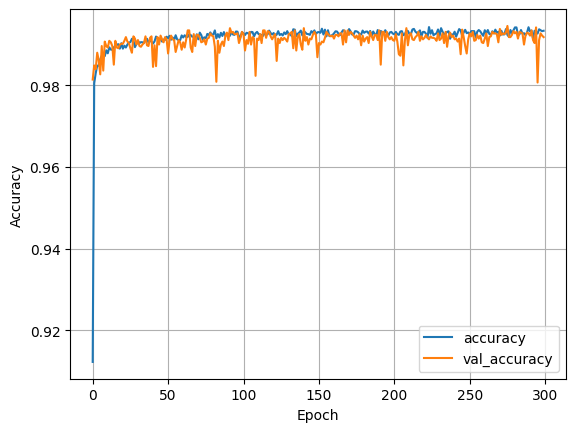

In [291]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [292]:
from sklearn.metrics import accuracy_score
accuracy =  accuracy_score(y_test, y_pred)
accuracy * 100

92.1930447125621